<h1>Содержание:<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследование-пользовательского-поведения-в-мобильном-приложении" data-toc-modified-id="Исследование-пользовательского-поведения-в-мобильном-приложении-0">Исследование пользовательского поведения в мобильном приложении</a></span><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-0.1">Предобработка данных</a></span></li><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-0.2">Изучение данных</a></span><ul class="toc-item"><li><span><a href="#Количество-событий-в-логе,-количество-пользователей,-среднее-количество-событий-на-пользователя" data-toc-modified-id="Количество-событий-в-логе,-количество-пользователей,-среднее-количество-событий-на-пользователя-0.2.1">Количество событий в логе, количество пользователей, среднее количество событий на пользователя</a></span></li><li><span><a href="#Период-регистрации-данных" data-toc-modified-id="Период-регистрации-данных-0.2.2">Период регистрации данных</a></span></li><li><span><a href="#Выбор-актуального-периода" data-toc-modified-id="Выбор-актуального-периода-0.2.3">Выбор актуального периода</a></span></li><li><span><a href="#Оценка-отсеченных-данных" data-toc-modified-id="Оценка-отсеченных-данных-0.2.4">Оценка отсеченных данных</a></span></li><li><span><a href="#Количество-пользователей-в-группах" data-toc-modified-id="Количество-пользователей-в-группах-0.2.5">Количество пользователей в группах</a></span></li></ul></li><li><span><a href="#Воронка-событий" data-toc-modified-id="Воронка-событий-0.3">Воронка событий</a></span></li><li><span><a href="#Изучение-результатов-эксперимента" data-toc-modified-id="Изучение-результатов-эксперимента-0.4">Изучение результатов эксперимента</a></span></li></ul></li></ul></div>

# Исследование пользовательского поведения в мобильном приложении

## Предобработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
import numpy as np
import math as mth
from scipy import stats as st

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Согласно документации к данным:
* `EventName` — название события;
* `DeviceIDHash` — уникальный идентификатор пользователя;  
* `EventTimestamp` —  время события;
* `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Преобразуем столбцы

In [3]:
df.columns = (df.columns).str.lower()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   eventname       244126 non-null  object
 1   deviceidhash    244126 non-null  int64 
 2   eventtimestamp  244126 non-null  int64 
 3   expid           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
df.columns = ['event', 'device_id', 'event_timestamp', 'exp_id']

Проверим дубликаты

In [6]:
df.duplicated().sum()

413

In [7]:
df = df.drop_duplicates().reset_index()

Добавим столбец даты и времени

In [8]:
df['dt'] = pd.to_datetime(df['event_timestamp'], unit='s')

Добавим отдельный столбец для дат

In [9]:
df['date'] = df['dt'].dt.date

**Вывод:**

Симпатичные данные. Пропусков нет, от дубликатов избавились.

## Изучение данных

### Количество событий в логе, количество пользователей, среднее количество событий на пользователя

*Сколько всего событий в логе?*

In [10]:
events = len(df)
events

243713

*Сколько всего пользователей в логе?*

In [11]:
users = len(df.groupby('device_id').agg({'device_id': 'nunique', 'event': 'nunique'}))
users

7551

*Сколько в среднем событий приходится на пользователя?*

In [12]:
#event_per_user = df.groupby('device_id').agg({'device_id': 'nunique', 'event': 'nunique'})['event'].mean()
#round(event_per_user,2)

In [13]:
event_per_user = events/users
round(event_per_user,2)

32.28

### Период регистрации данных

Начало регистрации данных

In [14]:
print('Начало регистрации данных:',df['dt'].min())

Начало регистрации данных: 2019-07-25 04:43:36


Конец регистрации данных

In [15]:
print('Конец регистрации данных:',df['dt'].max())

Конец регистрации данных: 2019-08-07 21:15:17


### Выбор актуального периода

Посмотрим на график

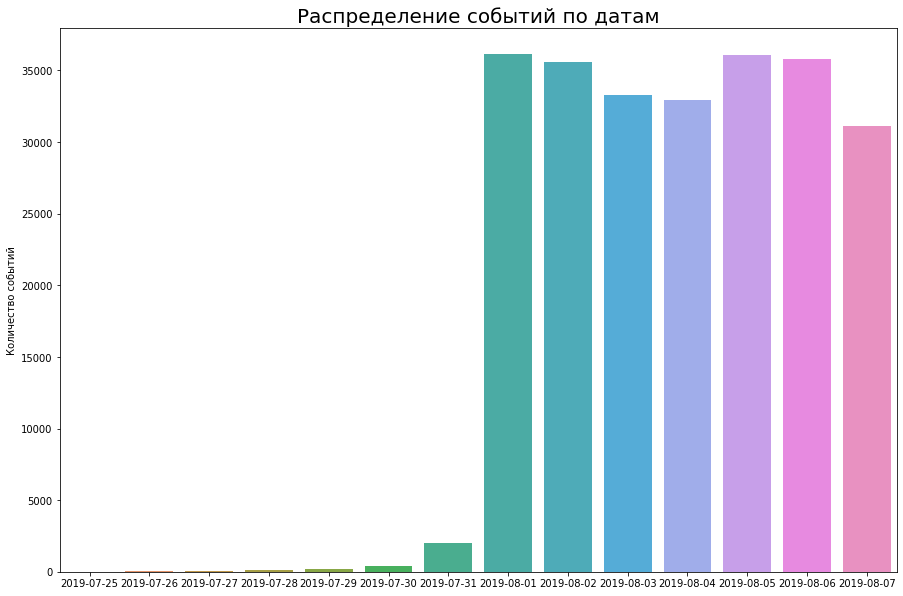

In [16]:
distr = df.groupby('date').agg({'event': 'count'}).reset_index()

plt.subplots(figsize=(15, 10))

ax = sns.barplot(x="date", y="event", data=distr)

plt.title('Распределение событий по датам', size='20')
plt.ylabel('Количество событий')
plt.xlabel(None);

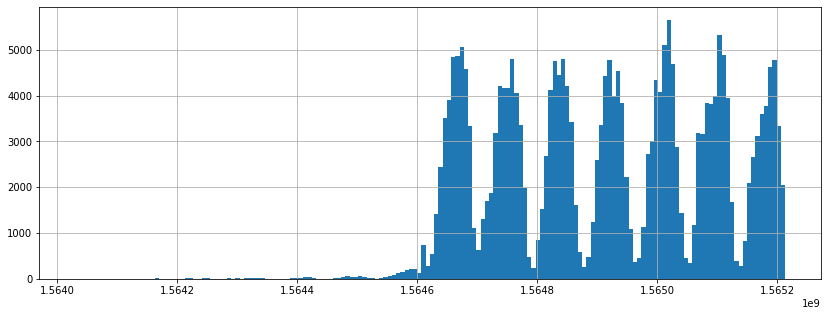

In [17]:
df['event_timestamp'].hist(bins=7*24, figsize=(14, 5));

На графике видно, что значимая часть зарегистрированных событий приходится на период с 2019-08-01 по 2019-08-07. 

In [18]:
df = df.query('dt >= "2019-08-01"')

### Оценка отсеченных данных

In [19]:
print('Всего событий в логе после фильтрации:', len(df))
print('Доля оставшихся событий:', round(len(df) / events * 100, 2),'%')

Всего событий в логе после фильтрации: 240887
Доля оставшихся событий: 98.84 %


In [20]:
users_filter = len(df.groupby('device_id').agg({'device_id': 'nunique', 'event': 'nunique'}))
print('Всего пользователей в логе после фильтрации:',users_filter)
print('Доля оставшихся пользователей:',round(users_filter / users * 100, 2), '%')

Всего пользователей в логе после фильтрации: 7534
Доля оставшихся пользователей: 99.77 %


Потеряли очень небольшой процент данных.

### Количество пользователей в группах

In [21]:
groups = df.groupby('exp_id').agg({'device_id': 'nunique'})
groups['part'] = round(groups['device_id'] / users_filter * 100)
groups.columns = ['Количество пользователей','%']
groups

,Количество пользователей,%
exp_id,,
246,2484,33.0
247,2513,33.0
248,2537,34.0


**Вывод:**

Изучив данные, можно сказать, что всего в логе произошло 243713 событий с 7551 пользователями. С помощью графика распределения мы определили, что основная часть зарегистрированных данных приходится после 2019-07-31. Отфильтровав неактуальные даты мы сохранили примерно 99% данных. Оставшиеся пользователи поделены на три примерно равнозначные группы, что говорит об оптимальном сборе данных.

## Воронка событий

In [22]:
users_filter

7534

Создадим таблицу с названием событий, их количеством, количеством пользователей и посчитаем процент от общего числа пользователей.

In [23]:
event_funnel = df.groupby('event').agg({'device_id': ['count', 'nunique']}).reset_index()
event_funnel.columns = ['Событие', 'Количество событий', 'Количество пользователей']
event_funnel['% пользователей'] = round(100*event_funnel['Количество пользователей'] / users_filter,2)
event_funnel =event_funnel.sort_values(by='Количество пользователей', ascending=False)
event_funnel

,Событие,Количество событий,Количество пользователей,% пользователей
1,MainScreenAppear,117328,7419,98.47
2,OffersScreenAppear,46333,4593,60.96
0,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97
4,Tutorial,1005,840,11.15


In [24]:
event_funnel= event_funnel.loc[:3] # отбросим tutorial

In [25]:
!pip install -U kaleido

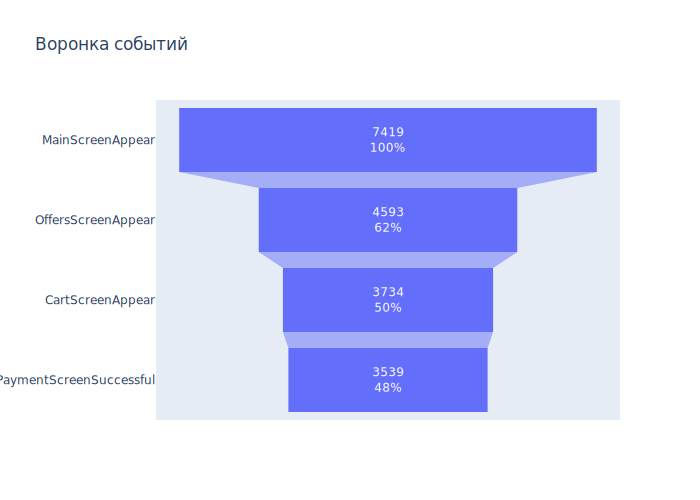

In [26]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    y=event_funnel['Событие'],
    x=event_funnel['Количество пользователей'],
    textposition = "inside",
    textinfo = "value+percent initial",
    ))
fig.layout.title= 'Воронка событий'
fig.show("svg")

**Вывод:** На главный экран приложения попадает 7419 пользователей. Вероятно 1,5% пользователей не могут совершить это действие из-за персональных проблем с подключением к интернету. Далее 4593 (61%) пользователей решаются совершить заказ и открывают окно оформления. До корзины доходят 3734 (50%) пользователей и 3539 (48%) совершают заказ. Не совсем понимаю что за шаг Tutorial, возможно это открытие инструкции как совершить то или иное действие.

In [27]:
event_funnel['шаговый % пользователей'] = round(100*event_funnel['Количество пользователей']/event_funnel['Количество пользователей'].shift(1),2)
event_funnel

/tmp/ipykernel_267/3183577960.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Событие,Количество событий,Количество пользователей,% пользователей,шаговый % пользователей
1,MainScreenAppear,117328,7419,98.47,NaN
2,OffersScreenAppear,46333,4593,60.96,61.91
0,CartScreenAppear,42303,3734,49.56,81.30
3,PaymentScreenSuccessful,33918,3539,46.97,94.78


Рассмотрим эти действия с пошаговой конверсией 

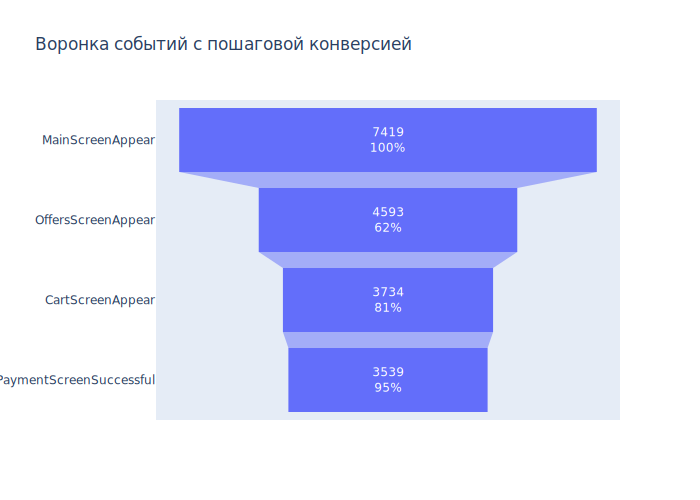

In [28]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    y=event_funnel['Событие'],
    x=event_funnel['Количество пользователей'],
    textposition = "inside",
    textinfo = "value+percent previous",
    ))
fig.layout.title= 'Воронка событий с пошаговой конверсией'
fig.show("svg")

**Вывод:** 40 % пользователей отваливаются на шаге к оформлению заказа. Мне кажется вполне приемлимым показателем, возможно присматриваются, чтобы купить позже. 80 % от оставшихся добавляют свои товары в корзину, и 95 % из них все-таки покупают.

## Изучение результатов эксперимента 

Определим сколько пользователей в каждой экспериментальной группе

In [29]:
event_exp = df.pivot_table(index='event', columns='exp_id', values='device_id', aggfunc='nunique')
event_exp.columns = ['246', '247', '248']
event_exp = event_exp.sort_values(by='246', ascending=False).reset_index()
event_exp = event_exp.loc[:3] # отбросим tutorial
event_exp['246+247'] = event_exp['246'] + event_exp['247']
event_exp

,event,246,247,248,246+247
0,MainScreenAppear,2450,2476,2493,4926
1,OffersScreenAppear,1542,1520,1531,3062
2,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358


Проверим наличие пользователей в разных группах

In [30]:
df.groupby('device_id')['exp_id'].nunique().reset_index().query('exp_id > 1')

,device_id,exp_id


Как хорошо, что их нет

Построим воронку событий по группам

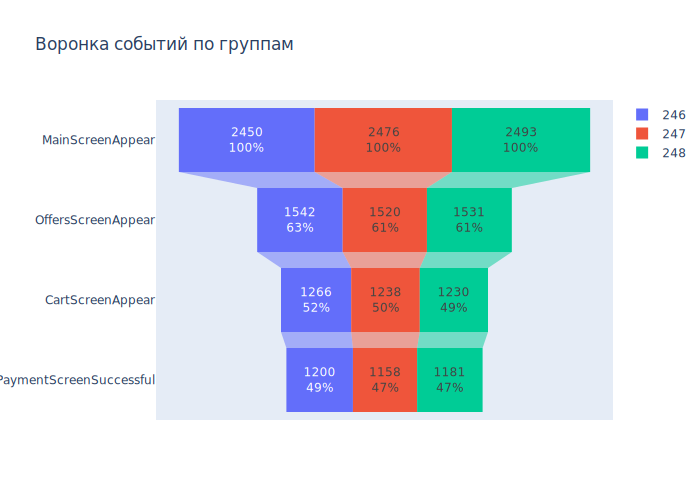

In [31]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = '246',
    y = event_exp['event'],
    x = event_exp['246'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = '247',
    orientation = "h",
    y = event_exp['event'],
    x = event_exp['247'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = '248',
    orientation = "h",
    y = event_exp['event'],
    x = event_exp['248'],
    textposition = "inside",
    textinfo = "value+percent initial"))
fig.layout.title= 'Воронка событий по группам'
fig.show("svg")

В целом воронка равномерна. Посмотрим на результаты z-теста на проверку статистической значимости разницы.

**A/A - тест**

Выбираем метод z-теста, так как нам необходимо проверить гипотезы для долей.

H0: доли уникальных посетителей, побывавших на этапе воронки, одинаковы.

Н1: между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.

alpha = 0.05

In [32]:
#функциядля проверки гипотезы
def hypothesis(pur1, pur2, lead1, lead2, alp):
    alpha = alp  # критический уровень статистической значимости

    purchases = np.array([pur1, pur2])
    leads = np.array([lead1, lead2])

# пропорция успехов в первой группе:
    p1 = purchases[0]/leads[0]

# пропорция успехов во второй группе:
    p2 = purchases[1]/leads[1]
    

# пропорция успехов в комбинированном датасете:
    p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])

# разница пропорций в датасетах
    difference = p1 - p2 

    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / leads[0] + 1 / leads[1])
    )
    distr = st.norm(0, 1)

    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

   
    print('p-значение: ', p_value)
  
    
    if p_value < alpha:# ваш код
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )
    print()    

In [33]:
groups = groups.T 

groups.columns = ['246', '247', '248']
groups['246+247'] = groups['246'] + groups['247']
groups

,246,247,248,246+247
Количество пользователей,2484.0,2513.0,2537.0,4997.0
%,33.0,33.0,34.0,66.0


In [34]:
def check_hyp(data, col1, col2, alp):
    for i in range(0, 3):
        print('Результат z-теста: Группы', col1, 'и', col2, ', Cобытие:', data.loc[i+1, 'event'])
        print()
        
        hypothesis(data.loc[i+1, col1], data.loc[i+1, col2], groups.loc['Количество пользователей', col1], groups.loc['Количество пользователей', col2], alp)

In [35]:
check_hyp(event_exp, '246', '247', 0.05)

Результат z-теста: Группы 246 и 247 , Cобытие: OffersScreenAppear

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 246 и 247 , Cобытие: CartScreenAppear

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 246 и 247 , Cобытие: PaymentScreenSuccessful

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:** тест проведен корректно, между группами нет статистически значимых различий.

**A/B - тест**

Сформулируем нулевую и алетернативные гипотезы:

H0: между группами нет статистической значимой разницы

Н1: между группами есть статистическая значимая разница

alpha = 0.05

**246 и 248**

In [36]:
check_hyp(event_exp, '246', '248', 0.05)

Результат z-теста: Группы 246 и 248 , Cобытие: OffersScreenAppear

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 246 и 248 , Cобытие: CartScreenAppear

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 246 и 248 , Cобытие: PaymentScreenSuccessful

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**247 и 248**

In [37]:
check_hyp(event_exp, '247', '248', 0.05)

Результат z-теста: Группы 247 и 248 , Cобытие: OffersScreenAppear

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 247 и 248 , Cобытие: CartScreenAppear

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 247 и 248 , Cобытие: PaymentScreenSuccessful

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**246+247 и 248**

In [38]:
check_hyp(event_exp, '248', '246+247', 0.05)

Результат z-теста: Группы 248 и 246+247 , Cобытие: OffersScreenAppear

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 248 и 246+247 , Cобытие: CartScreenAppear

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 248 и 246+247 , Cобытие: PaymentScreenSuccessful

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Между группами нет статистической значимой разницы. Вывод о различии сделать нельзя.**

Проведем тест с поправкой Бонферрони

In [39]:
bon = 0.05 / 12

In [40]:
check_hyp(event_exp, '246', '247', bon)

Результат z-теста: Группы 246 и 247 , Cобытие: OffersScreenAppear

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 246 и 247 , Cобытие: CartScreenAppear

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 246 и 247 , Cобытие: PaymentScreenSuccessful

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



check_hyp(event_exp, '246', '248', bon)

In [41]:
check_hyp(event_exp, '247', '248', bon)

Результат z-теста: Группы 247 и 248 , Cобытие: OffersScreenAppear

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 247 и 248 , Cобытие: CartScreenAppear

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 247 и 248 , Cобытие: PaymentScreenSuccessful

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [42]:
check_hyp(event_exp, '248', '246+247', bon)

Результат z-теста: Группы 248 и 246+247 , Cобытие: OffersScreenAppear

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 248 и 246+247 , Cобытие: CartScreenAppear

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 248 и 246+247 , Cобытие: PaymentScreenSuccessful

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Даже с поправкой Бонферрони тест говорит, что между группами нет значительных различий.

**Вывод:**

На этапе подготовки А/B теста был проведен A/A тест, где выяснилось, что статистически значимых различий между двумя А группами нет значит, что пользователи относятся к той или иной группе случайно,следовательно А/А тест проведен корректно. 

По результатам А/B теста статистически значимых различий между А и В группами (в том числе с объединенной группой) также не обнаружили - это значит, что наша гипотеза о том, что изменение шрифта на главной странице как-то повлияет на наши метрики не верна.

По результатам эксперимента можно сделать вывод, что изменение шрифта положительно не повлияло на поведение пользователей